In [2]:
#from puppy.unfolder import PhononUnfolder
#from puppy.plotting import UnfolderPlotting
#from puppy.unfolder import * 
#import matplotlib.pyplot as plt

In [42]:
!export OMP_NUM_THREADS=1

In [1]:
import os
from phonopy import load
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
from pymatgen.core import Structure
import itertools as it
from ase import io
from ase.dft.kpoints import *
import numpy as np 
from phonopy.file_IO import parse_FORCE_SETS
from phonopy.interface.vasp import read_vasp 
from phonopy.structure.cells import get_supercell
from phonopy import Phonopy
from phonopy.unfolding.core import Unfolding
from phonopy.interface.calculator import read_crystal_structure
from phonopy.phonon.band_structure import BandStructure, get_band_qpoints,get_band_qpoints_by_seekpath
from pymatgen.io.phonopy import eigvec_to_eigdispl

class PhononUnfolder:
    
    def __init__(self,dict_of_locations,expansion,**kwargs):
        self.data = dict_of_locations
        self.expansion = expansion
        self.line_density = 101
        
    def get_possible_path(self,tol=0.01):
        atoms = io.read(filename=os.path.join(self.data['host_directory'],'POSCAR')) 
        points = get_special_points(atoms.cell, eps=tol)
        kpath  = {}
        lists = list(points.keys())
        for i,k in enumerate(lists):
            if not i == len(lists)-1:
                k1,k2 = lists[i],lists[i+1]
                kpath['{}-{}'.format(k1,k2)] = [points[k1],points[k2]]
        return(kpath)
    
    def get_phonopy_defect_data_2(self,line_density=101): # rehash to not use phonopy but pymatgen
        '''generates a phonopy band structure object from the defect supercell
        todo:
        * make it so you can use .gz files
        * add custom kpoint path without the kernel crashing'''
        bands,labels,path_connections = get_band_qpoints_by_seekpath(primitive=self.primitive,
                                                             npoints=line_density,
                                                             is_const_interval=True)
        ph = load(supercell_filename=os.path.join(self.data['defect_directory'],'SPOSCAR'),
                  force_sets_filename=os.path.join(self.data['defect_directory'],'FORCE_SETS'),
                  log_level=0)
        ph.run_band_structure(bands,
                              with_eigenvectors=True,
                              path_connections=path_connections,
                              labels=labels)
        band_data = ph.get_band_structure_dict()
        self.defect_band_data = band_data
        self.defect_band_data['connections'] = path_connections
        self.supercell = ph.supercell
        self.defect_phonons = ph
        self.labels = labels
        self.special_points = [x[0] for x in ph.band_structure.qpoints]
        self.special_points.append(ph.band_structure.qpoints[-1][-1])
    
    def get_phonopy_primitive_data_2(self,line_density=101):
        '''todo:
        * make it so you can use .gz files
        * add custom kpoint path without the kernel crashing'''
        ph = load(supercell_filename=os.path.join(self.data['host_directory'],'SPOSCAR'),
                  force_sets_filename=os.path.join(self.data['host_directory'],'FORCE_SETS'),
                  log_level=0)
        ph.auto_band_structure(with_eigenvectors='False')
        band_data=ph.get_band_structure_dict()
        self.primitive_band_data = band_data
        self.primitive = ph.primitive
        self.primitive_phonons = ph
    
    @staticmethod   
    def label_formatter(labels,special_points):
        labs = []
        for i,j in enumerate(labels):
            if j == '$\\Gamma$':
                labs.append({'G':special_points[i]})
            else:
                clean = j.split('$')[1].split('{')[1].split('}')[0]            
                labs.append({clean:special_points[i]})
        return(labs)

    def get_primitive_qpts(self,tol=0.01,line_density=100):
        points = get_special_points(self.primitive.cell, eps=tol)
        kpath = self.label_formatter(self.labels,self.special_points)
        Q = [x for k in kpath for x,y in points.items() if all(y==k)]
        Q = list(points)
        path = bandpath(Q,atoms.cell,line_density) 
        qpts = path.kpts
        (q,line,label) = path.get_linear_kpoint_axis()        
        return({'q':q,'line':line,'label':label,'qpts':qpts})
    
    def get_neighbour_sites(self,tol=3):
        struct = Structure.from_file(os.path.join(self.data['host_directory'],'SPOSCAR'))
        nearest_neighbours = struct.get_neighbor_list(tol,
                                                      sites=[struct.sites[self.data['defect_index']]])[1]
        unique_elements = list(dict.fromkeys([x.species_string for x in struct.sites]))
        neighbours = {}
        for elem in unique_elements:
            neighbours[elem] = [x for x in nearest_neighbours 
                                if struct.sites[x].species_string == elem]
        return(neighbours)
    
    def get_eigendisplacements(self,band_data,sites):
    
        supercell, _ = read_crystal_structure(os.path.join(self.data['defect_directory'],'SPOSCAR'),
                                              interface_mode='vasp')
        atom_coords = supercell.get_scaled_positions()
        num_atoms = supercell.get_number_of_atoms()
        masses = supercell.get_masses()
        qpoints = band_data['qpoints'] # what is this all about? surely we should do more?
        distances = band_data['distances']
        frequencies = band_data['frequencies']
        eigenvectors = np.asarray(band_data['eigenvectors'],dtype='object') # check this!!!!!!
        connections = band_data['connections']
        true_q = [i for i in connections if i]        
        #iterations = int(np.product(np.shape(eigenvectors)[0:3]))
        

        
        total = [] # we want one "displacement" per qpoint and frequency based on sites in radius around defect
        #with tqdm(total=iterations,disable=self.progress) as pbar:
        for i in range(len(true_q)):
            total.append([])
            for q in range(len(qpoints[i])):
                total[i].append([])
                for w in range(len(frequencies[i][q])):
                
                    mean = [[np.linalg.norm(eigvec_to_eigdispl(eigenvectors[i][q][w][at],
                                                                          q=qpoints[i][q],
                                                                          frac_coords=atom_coords[at],
                                                                          mass=masses[at])) for elem in sites if elem == at] for at in range(num_atoms)]
                    total[i][q].append(np.mean(list(it.chain(*mean))))
   
        return(total)

    def phonon_unfolder(self,prim_data): # could make it allow alloys in future
        #preamble setup 
        qpts = prim_data['qpts']
        line = prim_data['line']
        labels = prim_data['label']
        dim = self.expansion

        if len(dim) == 9:
            smatrix = np.reshape(dim,[3,3])
        elif len(dim) == 3:
            smatrix = np.zeros(9)
            for i in range(len(dim)):
                smatrix[i*4] = dim[i]
            smatrix = np.reshape(smatrix,[3,3])
        
        defect_index = self.data['defect_index']
        forcesets = parse_FORCE_SETS(filename=os.path.join(self.data['defect_directory'],'FORCE_SETS'))  
        
        pmatrix = np.linalg.inv(smatrix) 
        # setting up phonopy object
        prim_cell = read_vasp(os.path.join(self.data['host_directory'],'POSCAR')) 
        perf_supercell = get_supercell(prim_cell,smatrix)
        def_supercell = read_vasp(os.path.join(self.data['defect_directory'],'SPOSCAR'))
        phonon = Phonopy(def_supercell,np.diag([1,1,1]))
        phonon.dataset = forcesets
        phonon.produce_force_constants()
        mapping = [x for x in range(perf_supercell.get_number_of_atoms())]
        mapping[defect_index] = None
        # unfolding
        unfold = Unfolding(phonon=phonon, 
                           supercell_matrix=smatrix, 
                           ideal_positions=perf_supercell.get_scaled_positions(),
                           atom_mapping=mapping,
                           qpoints=qpts)
        unfold.run()
        weights = unfold.get_unfolding_weights()
        freqs = unfold.get_frequencies()

        return({'f':freqs,'w':weights})
        
    def run_all(self,kpaths=None,site_tol=3,sym_tol=0.01,line_density=100,eigendisplacement_atom=None):
        # could be worth having an automatic kpath generator if not defined
        bs_p = self.get_phonopy_primitive_data([kpaths[kpath] for kpath in kpaths],line_density) # do the primitive kpoints all in one
        
        data = {}
        for kpath in kpaths: # this can be multiprocessed in future
            bs_d = self.get_phonopy_defect_data(kpaths[kpath],line_density)
            s = self.get_neighbour_sites(site_tol)
            pq = self.get_primitive_qpts(kpaths[kpath],sym_tol,line_density)
            u = self.phonon_unfolder(pq)
            if not eigendisplacement_atom == None:
                e = self.get_eigendisplacements(bs_d,s[eigendisplacement_atom])
                data[kpath] = {'bs':bs_d,'sites':s,'prim_data':pq,'unfolded_data':u,'eigendisplacements':e}
            else:
                data[kpath] = {'bs':bs_d,'sites':s,'prim_data':pq,'unfolded_data':u}
        return({'data':data,'prim':bs_p})

In [274]:
directories = {'defect_directory':'/Users/badw/Documents/ntnu-projects/LiAlCl4/pbesol/V_Li/2x2x1/V_Li/0/phonons/',
                     'host_directory':'/Users/badw/Documents/ntnu-projects/LiAlCl4/pbesol/phonons/2x2x1/',
                    'defect_index':6}


#directories = {'defect_directory':'/Users/badw/Documents/ntnu-projects/anti-perovskite/Li/Li3OCl/pbesol/phonons/3x3x3/v_li_init_phonons/',
#               'host_directory':'/Users/badw/Documents/ntnu-projects/anti-perovskite/Li/Li3OCl/pbesol/phonons/3x3x3/kpoint_convergence/k1,1,1/',
#               'defect_index':74}

### From Scratch 

In [275]:
# get primitive data and band structure 
import gzip,os
import tqdm_pathos 
from tqdm import tqdm


class Puppy:

    def __init__(self,
                 defect_directory,
                 host_directory,
                 line_density,
                 expansion):
        self.defect_directory = defect_directory
        self.host_directory = host_directory
        self.line_density = line_density
        self.expansion = expansion

    def file_unzip(self, 
                   files):
        '''unzips a .gz file if present
            TODO: remove unzipped files afterwards'''
        for file in files:
            if os.path.exists(file):
                with gzip.open(file, 'rb') as f_in, open(file.replace('.gz', ''), 'wb') as f_out:
                    f_out.writelines(f_in)
        

    def get_host_phonons(self):
        '''get the host or primitive phonons which the defect phonons will be unfolded back towards
        * currently assumes seekpath and has no manual kpoints mode, but this can be rectified in the future'''

        self.file_unzip([self.host_directory+'SPOSCAR.gz',
                         self.host_directory+'FORCE_SETS.gz'])
        
        ph = load(supercell_filename=self.host_directory+'SPOSCAR',
                  force_sets_filename=self.host_directory+'FORCE_SETS',
                  log_level=0)
        
        
        bands,labels,path_connections = get_band_qpoints_by_seekpath(primitive=ph.primitive,
                                                                     npoints=self.line_density,
                                                                     is_const_interval=False)
                
        ph.run_band_structure(bands,
                              with_eigenvectors=False,
                              path_connections=path_connections,
                              labels=labels) #old - needs to remove get_band_qpoints

        band_data = ph.get_band_structure_dict()
        self.host_band_data = band_data
        self.path_connections = path_connections
        self.labels=labels
        self.host = ph.primitive
        self.host_phonons = ph

    def get_defect_phonons(self):
        '''get the defect phonons which will be unfolded'''

        self.file_unzip([self.defect_directory+'SPOSCAR.gz',
                         self.defect_directory+'FORCE_SETS.gz'])
        
        bands,labels,path_connections = get_band_qpoints_by_seekpath(primitive=self.host,
                                                             npoints=self.line_density,
                                                             is_const_interval=False)
        
        ph = load(supercell_filename=self.defect_directory+'SPOSCAR',
                  force_sets_filename=self.defect_directory+'FORCE_SETS',
                  log_level=0)
                
        ph.run_band_structure(bands,
                              with_eigenvectors=False,
                              path_connections=path_connections,
                              labels=labels)
        

        band_data = ph.get_band_structure_dict()
        self.defect_band_data = band_data
        self.supercell = ph.supercell
        self.defect_phonons = ph
        self.special_points = [x[0] for x in ph.band_structure.qpoints]
        self.special_points.append(ph.band_structure.qpoints[-1][-1])

    def unfold(self):

        def mp_function(qpoints):
            mapping = [x for x in range(self.host_phonons.get_supercell().get_number_of_atoms())]
            mapping[directories['defect_index']] = None
            unfold = Unfolding(phonon = self.defect_phonons,
                   supercell_matrix = np.abs(np.linalg.inv(self.host_phonons.primitive_matrix).round(0)),
                   ideal_positions=self.host_phonons.get_supercell().get_scaled_positions(),
                   atom_mapping = mapping,
                   qpoints = qpoints
                   )
            unfold.run()
            weights = unfold.get_unfolding_weights()
            freqs = unfold.get_frequencies()
            return([freqs,weights])
        
        frequencies = []
        weights = []
        for q in tqdm(self.host_band_data['qpoints']):
            freqs,wts = mp_function(q)
            frequencies.append(freqs)
            weights.append(wts)

        self.unfold_data = {'f':frequencies,'w':weights}

    def plot_unfold(self,base_colour=(0.1,0.1,0.1)):
                
        import matplotlib.pyplot as plt 
        import matplotlib.colors as mcolors
        from sumo.plotting import sumo_base_style
        plt.style.use(sumo_base_style)


        unfolded_weights = self.unfold_data['w']
        unfolded_freq = self.unfold_data['f']

        norm = mcolors.Normalize(vmin=0,vmax=np.max(unfolded_weights))

        line = self.host_band_data['distances']
        path_connections = self.path_connections
        labels =self.labels
        distances = self.host_band_data['distances']

        axiscount = 1
        for i,x in enumerate(path_connections[:-1]):
            if i > 0 :
                if not path_connections[i] == path_connections[i-1]:
                    axiscount+=1

        import collections

        sizing = collections.Counter(path_connections[:-1]).values()

        fig,axes = plt.subplots(ncols=axiscount,figsize=(5,5),dpi=100,sharey=True,gridspec_kw={'width_ratios':sizing})

        axisvlines = [0]

        totallen = len(distances)
        count = 0 
        fig.axes[count].axvline(axisvlines[0])

        for i,(l,connect,label) in enumerate(zip(distances,path_connections,labels)):
            
            if not l[0] in axisvlines:
                fig.axes[count].axvline(l[0],color='k')
                axisvlines.append(l[0])
            if not l[-1] in axisvlines:
                fig.axes[count].axvline(l[0],color='k')
                axisvlines.append(l[-1])

            qpts = [[q for x in range(len(unfolded_freq[i][0]))] for q in line[i]]
            cols = [[mcolors.to_rgba(base_colour,alpha=unfolded_weights[i][w1][w2])
                            for w2 in range(len(unfolded_weights[i][w1]))] 
                           for w1 in range(len(unfolded_weights[i]))]
                
            for ii,qq in enumerate(qpts):
                collection = fig.axes[count].scatter(x=qq,y=unfolded_freq[i][ii],c=cols[ii],edgecolor=None,linewidths=0,norm=norm,s=5)
            
            if not connect:
                if not i == totallen:
                    count+=1    


        lefts = [0]
        rights = []
        for i, c in enumerate(path_connections):
            if not c:
                lefts.append(i + 1)
                rights.append(i)
            seg_indices = [list(range(lft, rgt + 1)) for lft, rgt in zip(lefts, rights)]
            special_points = []
            for indices in seg_indices:
                pts = [distances[i][0] for i in indices]
                pts.append(distances[indices[-1]][-1])
                special_points.append(pts)        

        l_count = 0         

        for ax, spts in zip(axes,special_points):
            ax.set_xticks(spts)
            ax.set_xlim(spts[0],spts[-1])
            ax.set_xticklabels(labels[l_count : (l_count + len(spts))])
            l_count += len(spts)        
        
        

        axes[0].set_ylabel('Frequency (THz)')    

        return(plt)


In [276]:
import warnings 
warnings.simplefilter('ignore')
puppy = Puppy(defect_directory=directories['defect_directory'],
              host_directory=directories['host_directory'],
              line_density=51,
              expansion=[3,3,3])

puppy.get_host_phonons()
puppy.get_defect_phonons()
puppy.unfold()

100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


TypeError: 'Axes' object is not iterable

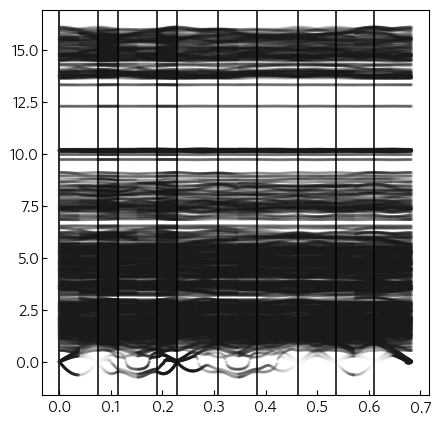

In [277]:
puppy.plot_unfold()

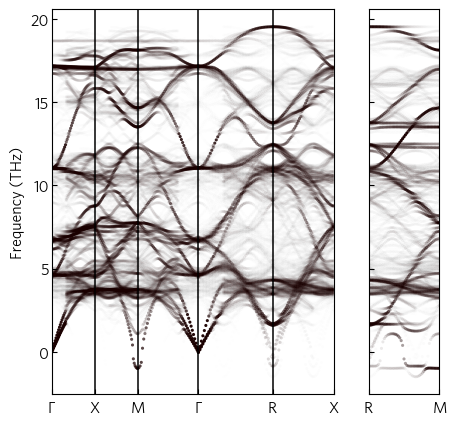

<Axes: ylabel='Frequency (THz)'>

In [255]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from sumo.plotting import sumo_base_style
plt.style.use(sumo_base_style)

base_colour = [0.1,0.0,0.0]
axiscount = 1
for i,x in enumerate(path_connections[:-1]):
    if i > 0 :
        if not path_connections[i] == path_connections[i-1]:
            axiscount+=1

import collections

sizing = collections.Counter(path_connections[:-1]).values()

fig,axes = plt.subplots(ncols=axiscount,figsize=(5,5),dpi=100,sharey=True,gridspec_kw={'width_ratios':sizing})

unfolded_weights = unfold['w']
norm = mcolors.Normalize(vmin=0,vmax=np.max(unfolded_weights))
unfolded_freq = unfold['f']

line = puppy.host_band_data['distances']
path_connections = puppy.path_connections
labels =puppy.labels
distances = puppy.host_band_data['distances']

axisvlines = [0]

totallen = len(distances)
count = 0 
fig.axes[count].axvline(axisvlines[0])

for i,(l,connect,label) in enumerate(zip(distances,path_connections,labels)):
    
    if not l[0] in axisvlines:
        fig.axes[count].axvline(l[0],color='k')
        axisvlines.append(l[0])
    if not l[-1] in axisvlines:
        fig.axes[count].axvline(l[0],color='k')
        axisvlines.append(l[-1])

    qpts = [[q for x in range(len(unfolded_freq[i][0]))] for q in line[i]]
    cols = [[mcolors.to_rgba(base_colour,alpha=unfolded_weights[i][w1][w2])
                    for w2 in range(len(unfolded_weights[i][w1]))] 
                   for w1 in range(len(unfolded_weights[i]))]
        
    for ii,qq in enumerate(qpts):
        collection = fig.axes[count].scatter(x=qq,y=unfolded_freq[i][ii],c=cols[ii],edgecolor=None,linewidths=0,norm=norm,s=5)
    
    if not connect:
        if not i == totallen:
            count+=1    


lefts = [0]
rights = []
for i, c in enumerate(path_connections):
    if not c:
        lefts.append(i + 1)
        rights.append(i)
    seg_indices = [list(range(lft, rgt + 1)) for lft, rgt in zip(lefts, rights)]
    special_points = []
    for indices in seg_indices:
        pts = [distances[i][0] for i in indices]
        pts.append(distances[indices[-1]][-1])
        special_points.append(pts)

l_count = 0 

for ax, spts in zip(axes,special_points):
    ax.set_xticks(spts)
    ax.set_xlim(spts[0],spts[-1])
    ax.set_xticklabels(labels[l_count : (l_count + len(spts))])
    l_count += len(spts)



axes[0].set_ylabel('Frequency (THz)')
plt.show()

fig.axes[0]

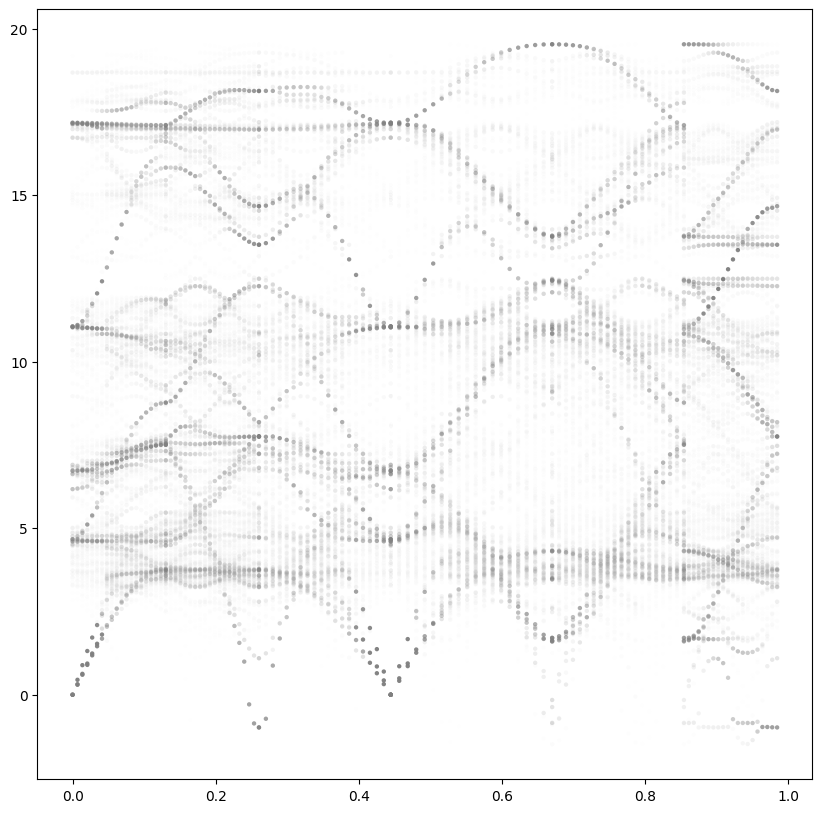

In [29]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
fig,ax = plt.subplots(figsize=(10,10),dpi=100)
unfolded_weights = unfold['w']
unfolded_freq = unfold['f']
line = puppy.host_band_data['distances']
norm = mcolors.Normalize(vmin=0,vmax=np.max(unfolded_weights))
for i,freq in enumerate(unfolded_freq):
    qpts = [[q for x in range(len(freq[0]))] for q in line[i]]
    cols = [[mcolors.to_rgba([0.5,0.5,0.5],alpha=unfolded_weights[i][w1][w2])
                for w2 in range(len(unfolded_weights[i][w1]))] 
               for w1 in range(len(unfolded_weights[i]))]
    
    for ii,qq in enumerate(qpts):
        ax.scatter(x=qq,y=freq[ii],c=cols[ii],edgecolor=None,linewidths=0,norm=norm,s=10)



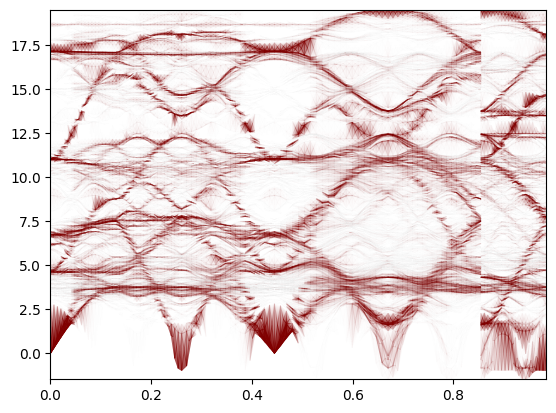

In [36]:
fig, ax = plt.subplots()
norm = mcolors.Normalize(vmin=0,vmax=np.max(unfolded_weights))
for i,freq in enumerate(unfolded_freq):
    qpts = [[q for x in range(len(freq[0]))] for q in line[i]]
    cols = [[mcolors.to_rgba([0.5,0,0],alpha=unfolded_weights[i][w1][w2])
                for w2 in range(len(unfolded_weights[i][w1]))] 
               for w1 in range(len(unfolded_weights[i]))]
    
    ax.pcolormesh(qpts, freq, cols, rasterized=True,shading='gouraud',norm=norm)

continue...

ValueError: RGBA values should be within 0-1 range

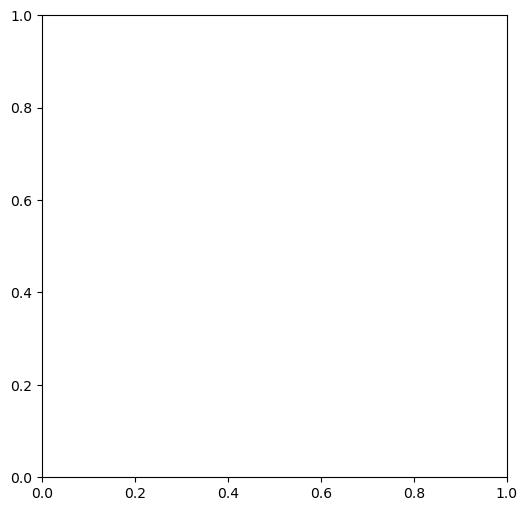

In [214]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colors as mcolors
import numpy as np
import itertools as it

fig,ax = plt.subplots(figsize=(6,6),dpi=100)

max_disp = []
for x in pup.eigendisplacements:
    for y in x:
            max_disp.append(np.max(y))
max_disp = np.max(max_disp)

for i in range(len(pup.defect_band_data['qpoints'])):
    vlabels = pup.prim_data['label']
    vlines = pup.prim_data['line']
    pq = pup.prim_data['q']
    maxpq = np.max(pq)
    threshold = 2

    uf = pup.unfolded_data['f']
    wts = pup.unfolded_data['w']
    eigendisp = pup.eigendisplacements[i]

                
    norm = Normalize(vmin=0.0,vmax=np.max(wts)) # this probably needs to be combined over the plot
        
    qpts = [[q for x in range(len(uf[i]))] for q in pq]

    col = [
            [
                    mcolors.to_rgba([eigendisp[w1][w2]/max_disp,0.0,0.0],
                                    alpha=wts[w1][w2]*threshold)

                    for w2 in range(len(wts[w1]))
                    ] 
                    for w1 in range(len(wts))
                    ]            

    col = []
    for w1 in range(len(wts)):
         col.append([])
         for w2 in range(len(wts[w1])):
              if eigendisp[w1][w2]/max_disp > 1:
                   print(eigendisp[w1][w2]/max_disp)
              col[w1] = mcolors.to_rgba((eigendisp[w1][w2],0.0,0.0))


    for j,q in enumerate(qpts):
        ax.scatter(q,uf[j],c=col[j],s=10,edgecolor=None,linewidths=0,norm=norm)

In [21]:
 import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colors as mcolors
import numpy as np
import itertools as it
def single_plot(pup,ax,threshold,s,primitive_bs=False):
        ax = ax
        
        labels = pup.prim_data['label']
        #q_line = self.data[i]['prim_data']['qpts']
        line = pup.prim_data['line']
        pq =pup.prim_data['q']
        
        uf = pup.unfolded_data['f']
        wts = pup.unfolded_data['w']
        
        norm = Normalize(vmin=0.0,vmax=np.max(wts))
        
        qpts = [[q for x in range(len(uf[0]))] for q in pq]

        col = [[mcolors.to_rgba([0.0,0.0,0.5],alpha=wts[w1][w2])
                for w2 in range(len(wts[w1]))] 
               for w1 in range(len(wts))]            
        
        for j,q in enumerate(qpts):
            ax.scatter(q,uf[j],c=col[j],s=s,edgecolor=None,linewidths=0,norm=norm)

        formatted_labels = ['$\\Gamma$' if x == 'G' else x for x in labels]        
        
        print(np.min(pq),np.max(pq))
        print(line)
        ax.set_xlim(np.min(pq),np.max(pq))
        ax.set_ylim(np.min(uf)-2,np.max(uf)+2)
        ax.set_xticks(line)
        ax.set_xticklabels(formatted_labels)
        vline = [ax.axvline(x,color='k') for x in line[1:-1]]
        print(formatted_labels)

/var/folders/40/xmstzxyn7377k__pn0yxn6w80000gn/T/ipykernel_72945/1742046419.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(q,uf[j],c=col[j],s=s,edgecolor=None,linewidths=0,norm=norm)


0.0 4.289225628736169
[0.         0.47101707 0.71698533 1.1880024  1.43397066 1.93718046
 2.40819753 2.91140732 3.36480794 3.83582501 4.28922563]
['$\\Gamma$', 'Z', 'D', 'Y', '$\\Gamma$', 'C', 'E', 'Z', 'A', 'X', '$\\Gamma$']


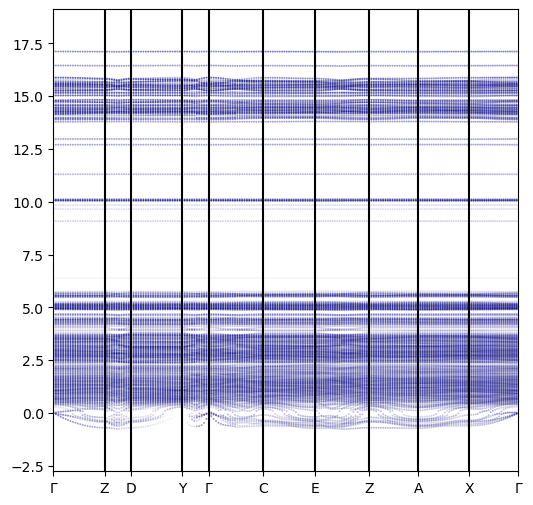

In [22]:
fig,ax = plt.subplots(figsize=(6,6),dpi=100)
single_plot(pup=pup,ax=ax,threshold=0.1,s=2)

In [122]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import colors as mcolors
import numpy as np
import itertools as it
   def single_plot_with_weight(pup,ax,threshold,s):
        ax = ax
        labels = []
        lines = []
        maxpq = None
        for i in enumerate(pup.data['data']):
            if i == 0:
a                labels.append(pup.prim_data['label'])
                lines.append(pup.prim_data['line'])
                pq = pup.prim_data['q']
                maxpq = np.max(pq)
                
                uf = pup.data['data'][path]['unfolded_data']['f']
                wts = self.data['data'][path]['unfolded_data']['w']
                eigendisp = self.data['data'][path]['eigendisplacements']
                max_disp = np.max(eigendisp) 
                
                norm = Normalize(vmin=0.0,vmax=np.max(wts)) # this probably needs to be combined over the plot
        
                qpts = [[q for x in range(len(uf[0]))] for q in pq]
                col = [[mcolors.to_rgba([eigendisp[1][w1][w2]/max_disp,0.0,0.0],alpha=wts[w1][w2]*threshold)
                        for w2 in range(len(wts[w1]))] 
                       for w1 in range(len(wts))]            
        
                for j,q in enumerate(qpts):
                    ax.scatter(q,uf[j],c=col[j],s=s,edgecolor=None,linewidths=0,norm=norm)
                
            else:
                labels.append(self.data['data'][path]['prim_data']['label'])
                lines.append(self.data['data'][path]['prim_data']['line'])
                pq = self.data['data'][path]['prim_data']['q']+maxpq
                maxpq = np.max(pq)
                
                uf = self.data['data'][path]['unfolded_data']['f']
                wts = self.data['data'][path]['unfolded_data']['w']
                eigendisp = self.data['data'][path]['eigendisplacements']
                max_disp = np.max(eigendisp) 
                
                norm = Normalize(vmin=0.0,vmax=np.max(wts)) # this probably needs to be combined over the whole plot
        
                qpts = [[q for x in range(len(uf[0]))] for q in pq]
                col = [[mcolors.to_rgba([eigendisp[1][w1][w2]/max_disp,0.0,0.0],alpha=wts[w1][w2]*threshold)
                        for w2 in range(len(wts[w1]))] 
                       for w1 in range(len(wts))]            
        
                for j,q in enumerate(qpts):
                    ax.scatter(q,uf[j],c=col[j],s=s,edgecolor=None,linewidths=0,norm=norm)


IndexError: list index out of range